# Introduction

Creating new features from the raw data is one of the best ways to improve your model. For example, when working with Kickstarter data, you can calculate the number of total projects in the last week and the duration of the fundraising period. The features you create are different for every dataset, so it takes a bit of creativity and experimentation. We're a bit limited here, since we're working with only one table. Typically you'll have access to multiple tables with relevant data that you can use to create new features.

But you can still see how to make new features using categorical features, and then a few examples of generated numerical features. 

In [1]:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.preprocessing import LabelEncoder

ks = pd.read_csv('../input/kickstarter-projects/ks-projects-201801.csv',
                 parse_dates=['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

# Interactions

One of the easiest ways to create new features is by combining categorical variables. For example, if one record has the country `"CA"` and category `"Music"`, you can create a new value `"CA_Music"`. This is a new categorical feature that can provide information about correlations between categorical variables. This type of feature is typically called an **interaction**. 

In general, you would build interaction features from all pairs of categorical features. You can make interactions from three or more features as well, but you'll tend to get diminishing returns.

Pandas lets us simply add string columns together like normal Python strings.

In [2]:
interactions = ks['category'] + "_" + ks['country']
print(interactions.head(5))

0            Poetry_GB
1    Narrative Film_US
2    Narrative Film_US
3             Music_US
4      Film & Video_US
dtype: object


Then, we can label encode the interaction feature and add it to our data.

In [3]:
label_enc = LabelEncoder()
data_interaction = baseline_data.assign(category_country=label_enc.fit_transform(interactions))
data_interaction.head()

,goal,hour,day,month,year,outcome,category,currency,country,category_country
0,1000.0,12,11,8,2015,0,108,5,9,1900
1,30000.0,4,2,9,2017,0,93,13,22,1630
2,45000.0,0,12,1,2013,0,93,13,22,1630
3,5000.0,3,17,3,2012,0,90,13,22,1595
4,19500.0,8,4,7,2015,0,55,13,22,979


In the exercise, you'll build interaction terms for all pairs of categorical features.

# Number of projects in the last week

Next, we'll count the number of projects launched in the preceeding week for each record. I'll use the `.rolling` method on a series with the `"launched"` column as the index. I'll create the series, using `ks.launched` as the index and `ks.index` as the values, then sort the times. Using a time series as the index allows us to define the rolling window size in terms of hours, days, weeks, etc.

In [4]:
# First, create a Series with a timestamp index
launched = pd.Series(ks.index, index=ks.launched, name="count_7_days").sort_index()
launched.head(20)

launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
1970-01-01 01:00:00      2842
1970-01-01 01:00:00    273779
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
2009-04-25 17:36:21    325391
2009-04-27 14:10:39    122662
2009-04-28 13:55:41    213711
2009-04-29 02:04:21    345606
2009-04-29 02:58:50    235255
2009-04-29 04:37:37     98954
2009-04-29 05:26:32    342226
2009-04-29 06:43:44    275091
2009-04-29 13:52:03    284115
2009-04-29 22:08:13     32898
Name: count_7_days, dtype: int64

There are seven projects that have obviously wrong launch dates, but we'll just ignore them. Again, this is something you'd handle when cleaning the data, but it's not the focus of this mini-course.

With a timeseries index, you can use `.rolling` to select time periods as the window. For example `launched.rolling('7d')` creates a rolling window that contains all the data in the previous 7 days. The window contains the current record, so if we want to count all the *previous* projects but not the current one, we'll need to subtract 1. We'll plot the results to make sure it looks right.

launched
1970-01-01 01:00:00     0.0
1970-01-01 01:00:00     1.0
1970-01-01 01:00:00     2.0
1970-01-01 01:00:00     3.0
1970-01-01 01:00:00     4.0
1970-01-01 01:00:00     5.0
1970-01-01 01:00:00     6.0
2009-04-21 21:02:48     0.0
2009-04-23 00:07:53     1.0
2009-04-24 21:52:03     2.0
2009-04-25 17:36:21     3.0
2009-04-27 14:10:39     4.0
2009-04-28 13:55:41     5.0
2009-04-29 02:04:21     5.0
2009-04-29 02:58:50     6.0
2009-04-29 04:37:37     7.0
2009-04-29 05:26:32     8.0
2009-04-29 06:43:44     9.0
2009-04-29 13:52:03    10.0
2009-04-29 22:08:13    11.0
Name: count_7_days, dtype: float64


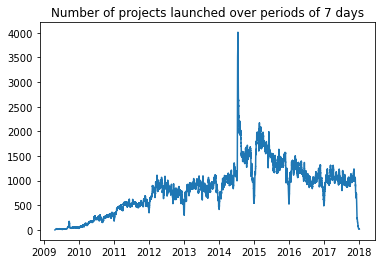

In [5]:
count_7_days = launched.rolling('7d').count() - 1
print(count_7_days.head(20))

# Ignore records with broken launch dates
plt.plot(count_7_days[7:]);
plt.title("Number of projects launched over periods of 7 days");

Now that we have the counts, we need to adjust the index so we can join it with the other training data. 

In [6]:
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)

In [7]:
count_7_days.head(10)

0    1409.0
1     957.0
2     739.0
3     907.0
4    1429.0
5    1284.0
6    1119.0
7    1391.0
8    1043.0
9    3199.0
Name: count_7_days, dtype: float64

Now join the new feature with the other data again using `.join` since we've matched the index.

In [8]:
baseline_data.join(count_7_days).head(10)

,goal,hour,day,month,year,outcome,category,currency,country,count_7_days
0,1000.0,12,11,8,2015,0,108,5,9,1409.0
1,30000.0,4,2,9,2017,0,93,13,22,957.0
2,45000.0,0,12,1,2013,0,93,13,22,739.0
3,5000.0,3,17,3,2012,0,90,13,22,907.0
4,19500.0,8,4,7,2015,0,55,13,22,1429.0
5,50000.0,13,26,2,2016,1,123,13,22,1284.0
6,1000.0,18,1,12,2014,1,58,13,22,1119.0
7,25000.0,20,1,2,2016,0,41,13,22,1391.0
8,125000.0,18,24,4,2014,0,113,13,22,1043.0
9,65000.0,21,11,7,2014,0,39,13,22,3199.0


# Time since the last project in the same category

Do projects in the same category compete for donors? If you're trying to fund a video game and another game project was just launched, you might not get as much money. We can capture this by calculating the time since the last launch project in the same category.

A handy method for performing operations within groups is to use `.groupby` then `.transform`. The `.transform` method takes a function then passes a series or dataframe to that function for each group. This returns a dataframe with the same indices as the original dataframe. In our case, we'll perform a groupby on `"category"` and use transform to calculate the time differences for each category.

In [9]:
def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds() / 3600.

df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas.head(20)

,launched
94579,NaN
319002,NaN
247913,NaN
48147,NaN
75397,NaN
2842,0.000000
273779,NaN
169268,NaN
322000,NaN
138572,NaN


We get `NaN`s here for projects that are the first in their category. We'll need to fill those in with something like the mean or median. We'll also need to reset the index so we can join it with the other data.

In [10]:
# Final time since last project
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(baseline_data.index)
timedeltas.head(20)

,launched
0,18.606111
1,5.592778
2,1.313611
3,0.635000
4,16.661389
5,2.629722
6,0.367500
7,12.286111
8,14.243611
9,0.174722


# Transforming numerical features

The distribution of the values in `"goal"` shows that most projects have goals less than 5000 USD. However, there is a long tail of goals going up to $100,000. Some models work better when the features are normally distributed, so it might help to transform the goal values. Common choices for this are the square root and natural logarithm. These transformations can also help constrain outliers.

Here I'll transform the goal feature using the square root and log functions as examples.

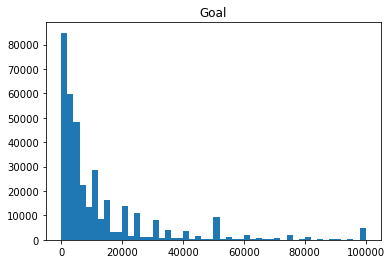

In [11]:
plt.hist(ks.goal, range=(0, 100000), bins=50);
plt.title('Goal');

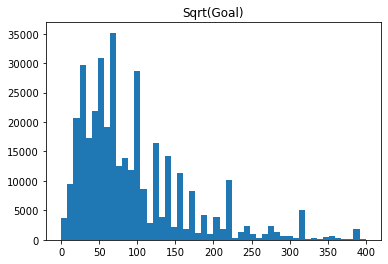

In [12]:
plt.hist(np.sqrt(ks.goal), range=(0, 400), bins=50);
plt.title('Sqrt(Goal)');

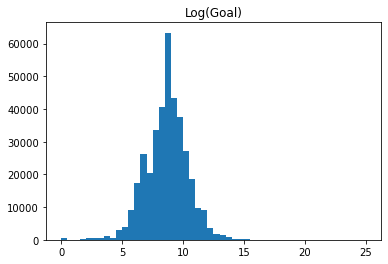

In [13]:
plt.hist(np.log(ks.goal), range=(0, 25), bins=50);
plt.title('Log(Goal)');

The log transformation won't help our model since tree-based models are scale invariant. However, this should help if we had a linear model or neural network.

Other transformations include squares and other powers, exponentials, etc. These might help the model discriminate, like the kernel trick for SVMs. Again, it takes a bit of experimentation to see what works. One method is to create a bunch of new features and later choose the best ones with feature selection algorithms.

# Your Turn
**[Try your hand at generating features](https://www.kaggle.com/kernels/fork/5407501)** to improve performance on your model from the previous exercise.

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/161443) to chat with other Learners.*